In [1]:
!pip install nlpaug

     |████████████████████████████████| 389kB 11.6MB/s 


In [2]:
!pip install transformers

     |████████████████████████████████| 1.3MB 12.7MB/s 
     |████████████████████████████████| 1.1MB 42.5MB/s 
     |████████████████████████████████| 890kB 39.8MB/s 
     |████████████████████████████████| 2.9MB 40.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=f16f1d75274b5f6413df204f8919b995288fead330cc1b826d8d7ae689d2e095
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore")
import datetime
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import scipy
from scipy import sparse

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir("/content/drive/My Drive/sentiment analysis") 

In [4]:
data=pd.read_csv("df_preprocessed_nw")
data=data.sort_values(by="dates")
data

,Unnamed: 0,Unnamed: 0.1,dates,reviews,reviews.doRecommend,y,polarity
0,16016,16016,2017-03-04 10:47:59.786,great great great great kids play easy monitor...,1,1,0.588889
1,16009,16009,2017-03-04 10:47:59.786,not meet needs not meet needs not meet needs n...,0,0,-0.250000
2,16010,16010,2017-03-04 10:47:59.786,great kids great kids great kids easy little o...,1,1,0.574306
3,16011,16011,2017-03-04 10:47:59.786,kid loves kid loves kid loves great tablet ...,1,1,0.393519
4,16015,16015,2017-03-04 10:47:59.786,great computer great computer great computer ...,1,1,0.625000
...,...,...,...,...,...,...,...
33776,29293,29293,2018-04-28 00:00:00.000,not satisfied sound loses bluetooth connec...,1,0,-0.050000
33777,29413,29413,2018-04-28 00:00:00.000,nice portable speaker alexa nice portable spea...,1,1,0.510000
33778,29469,29469,2018-04-28 00:00:00.000,difficult figure difficult figure difficult fi...,0,0,-0.233333
33779,29548,29548,2018-04-28 00:00:00.000,hands free hands free hands free echo not upda...,1,0,0.308333


### Augmentation of the reviews in train data

First let us try with the data augmentation techniques using the nlpaug library in python. There are three functions for charcher, word and sentence augmentation

In [5]:
import nlpaug
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas


In [9]:
#https://github.com/makcedward/nlpaug/blob/master/example/quick_example.ipynb
sent=data["reviews"][0]
print("Original sentence:>>> ",sent)
aug1=nac.KeyboardAug()
print("Charchter aug:>> ",aug1.augment(sent))

Original sentence:>>>  great great great great kids play easy monitor time spent content access 
Charchter aug:>>  great great great great kids plQy easg monitor time sOent content access


In [10]:
print("Original sentence:>>> ",sent)
aug2= naw.WordEmbsAug(model_type='glove', model_path='glove.6B.300d.txt')
print("Word aug:>> ",aug2.augment(sent))

Original sentence:>>>  great great great great kids play easy monitor time spent content access 
Word aug:>>  enormous great great great kids play easy monitor now lived content access


In [11]:
import transformers
aug3 = nas.ContextualWordEmbsForSentenceAug()
aug3.augment(sent) 

'great great great great kids play easy monitor time spent content access The _ - 3 D What We C E a M of " S F I _ in The 2 s I .'

We will consider the character and word augmentations and do this for the negative reviews

In [12]:
print(data["y"].value_counts())

1    31629
0     2153
Name: y, dtype: int64


In [13]:
neg=data[data["y"]==0]

#we take some random rows from this data set and do the augmentation. Then we concatenate this with the original data frame
# we consider all the negative reviews and do all te three augmentations


In [14]:
reviews=[]
polar=[]
date=[]
y_neg=[]
import tqdm 
from tqdm import tqdm
recommend=[]
for each in tqdm(range(neg.shape[0])):
  sent=neg.iloc[each]["reviews"]
  
  reviews.append(aug1.augment(sent))
  reviews.append(aug2.augment(sent))
  

  for i in range(2):
    polar.append(neg.iloc[each]["polarity"])
    date.append(neg.iloc[each]["dates"])
    y_neg.append(neg.iloc[each]["y"])
    recommend.append(neg.iloc[each]["reviews.doRecommend"])


100%|██████████| 2153/2153 [25:01<00:00,  1.43it/s]


In [20]:
aug_df=pd.DataFrame(columns=["dates",	"reviews","reviews.doRecommend",	"y",	"polarity"])
aug_df["dates"]=date
aug_df["reviews"]=reviews
aug_df["reviews.doRecommend"]=recommend
aug_df["y"]=y_neg
aug_df["polarity"]=polar
aug_df.to_csv("aug_df")

In [21]:
aug_df["y"].value_counts()


0    4306
Name: y, dtype: int64

In [22]:
final_df=pd.concat([data, aug_df])

In [25]:
final_df["y"].value_counts()
final_df.to_csv("final_df.csv")


In [6]:
final_df=pd.read_csv("final_df.csv")

In [7]:
final_df=final_df.sort_values(by="dates")

In [55]:
final_df["y"].value_counts()

1    31629
0     6459
Name: y, dtype: int64

In [8]:
final_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'dates', 'reviews',
       'reviews.doRecommend', 'y', 'polarity'],
      dtype='object')

In [9]:
final_df=final_df.drop(["Unnamed: 0","Unnamed: 0.1","Unnamed: 0.1.1"],axis=1)

Since we need to do time based split, we use numpy.split() and spit first 67% data into train and remaining 33% as test data

In [28]:
 
train, test= np.split(final_df, [int(.67 *len(final_df))])

In [29]:
print(train.shape)
train

(25518, 5)


,dates,reviews,reviews.doRecommend,y,polarity
0,2017-03-04 10:47:59.786,great great great great kids play easy monitor...,1,1,0.588889
33783,2017-03-04 10:47:59.786,not decide needs not not needs not meet needs ...,0,0,-0.250000
7,2017-03-04 10:47:59.786,great buy price great buy price great buy pric...,1,1,0.572727
6,2017-03-04 10:47:59.786,excellent learning device son excellent learni...,1,1,0.700000
5,2017-03-04 10:47:59.786,great toddler great toddler great toddler grea...,1,1,0.363750
...,...,...,...,...,...
22037,2017-08-27 00:00:00.000,fun product fun product fun product fun produc...,1,1,0.537500
22038,2017-08-27 00:00:00.000,one one one bought vacation electronics music ...,1,1,-0.150000
22039,2017-08-27 00:00:00.000,great tablet great tablet great tablet kindle ...,1,1,0.733333
22040,2017-08-27 00:00:00.000,great gift grandmother great gift grandmother ...,1,1,0.708333


In [30]:

print(test.shape)
test.tail()

(12570, 5)


,dates,reviews,reviews.doRecommend,y,polarity
33777,2018-04-28 00:00:00.000,not satisfied sound loses bluetooth connec...,1,0,-0.050000
33776,2018-04-28 00:00:00.000,perfect speaker house perfect speaker house pe...,1,1,0.950000
33775,2018-04-28 00:00:00.000,nice nice nice loud enough small gatherings re...,1,1,0.275000
33781,2018-04-28 00:00:00.000,portable portable portable wanted portable spe...,0,1,0.320476
38087,2018-04-28 00:00:00.000,hands free hands free hands free echo not upda...,1,0,0.308333


Now the features we consider for modeling are: reviews, reviews.dorecommend, polarity and the y values

### Featurization of text data

In [31]:
def featurization(train,test):
  tfidf=TfidfVectorizer()
  tfidf.fit(train["reviews"].values)
  train_text=tfidf.transform(train["reviews"].values)
  test_text=tfidf.transform(test["reviews"].values)
  print(train_text.shape)

  return train_text, test_text

In [32]:
train_text,test_text=featurization(train,test)
  

(25518, 18287)


In [33]:
# sparse.csr_matrix.sort_indices(test_text)

In [34]:
#now we merge the text features, polarity and do.recommend feature into x
from scipy.sparse import hstack

X_train=hstack((train_text,train["polarity"].values.reshape(-1,1),train["reviews.doRecommend"].values.reshape(-1,1)))
X_test=hstack((test_text,test["polarity"].values.reshape(-1,1),test["reviews.doRecommend"].values.reshape(-1,1)))
y_train=train["y"].values
y_test=test["y"].values
print(X_train.shape)
print(X_test.shape)

(25518, 18289)
(12570, 18289)


Since we splitted the data base on time, we need to check the distribution of classes in train and test

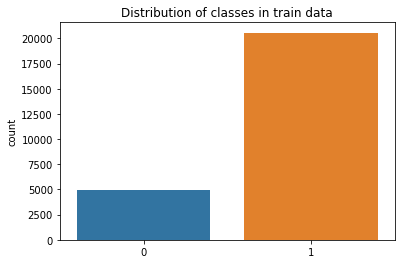

In [35]:
sns.countplot(y_train)
plt.title("Distribution of classes in train data")
plt.show()

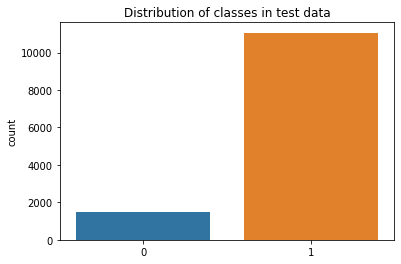

In [36]:
sns.countplot(y_test)
plt.title("Distribution of classes in test data")
plt.show()

The distribution of classes is similar in both train and test data.

### Modelling

In [37]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
y_pred_train=model.predict(X_train)

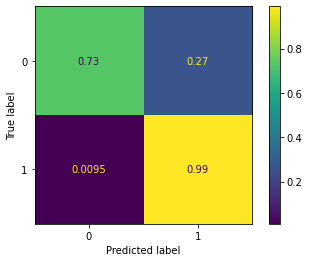

In [39]:
#confusion matrxi for train data
sklearn.metrics.plot_confusion_matrix(model, X_train, y_train,normalize="true") 

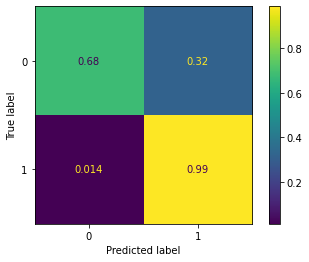

In [40]:
#confusion matrxi for test data
sklearn.metrics.plot_confusion_matrix(model, X_test, y_test,normalize="true") 

**OBSERVATIONS FROM THE LOGISTIC REGRESSION MODEL WITHOUT DATA BALANCING**

We can see that through augmnetation, the performance of the model on negative reviews has improved. 

Now let's check the performance of the model using data balancing

In [41]:
model=LogisticRegression(class_weight="balanced")
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

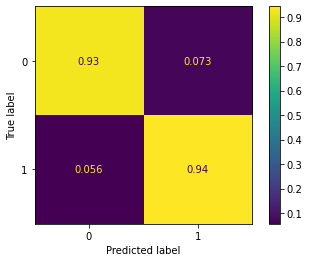

In [42]:
#confusion matrxi for train data
sklearn.metrics.plot_confusion_matrix(model, X_train, y_train,normalize="true") 

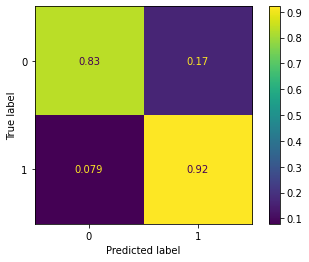

In [43]:
#confusion matrxi for test data
sklearn.metrics.plot_confusion_matrix(model, X_test, y_test,normalize="true") 

**Observations from logistic regression model:** We can see that the performance is highly improved when we balance the classes after augmentation in the text data. 

**Model 3-- XGBOOST**

In [44]:
import xgboost
from xgboost import XGBClassifier

In [45]:
model3=XGBClassifier()


### Hyper parameter tuning of the model



In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:

max_depth=[1,2,4,6]
n_estimators=[10,50,100,150,200]
params = {'max_depth': [1,2,4,6],'n_estimators': [10,50,100,150,200]}
best_model=GridSearchCV(model3,params,cv=3, scoring='roc_auc', return_train_score=True,n_jobs=-1,verbose=1)

In [48]:
best_model.fit(X_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 4, 6],
                         'n_estimators': [10, 50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_tra

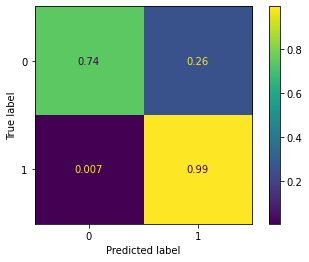

In [49]:

sklearn.metrics.plot_confusion_matrix(best_model, X_train, y_train,normalize="true") 

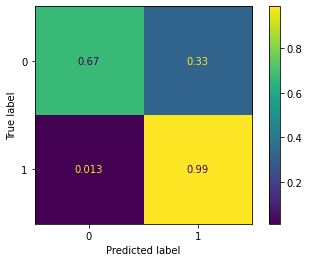

In [50]:
#confusion matrxi for test data
sklearn.metrics.plot_confusion_matrix(best_model, X_test, y_test,normalize="true") 

**OBSERVATION**

This model performed better than Logistic Regression model without balancing the data. Also, we can see that the predictions of negative reviews has improved due to the character and word augmentations. Now let us see if perfomance improve more with balanced data

Upsampling of negative reviews

In [54]:
from sklearn.utils import resample
df_majority = final_df[final_df.y==1]
df_minority = final_df[final_df.y==0]
df_minority_upsampled = resample(df_minority,replace=True,n_samples=df_majority.shape[0],random_state=123) # reproducible results
# Combine majority class with upsampled minority class
data_balanced = pd.concat([df_majority, df_minority_upsampled])
# Display new class counts
data_balanced.y.value_counts()

1    31629
0    31629
Name: y, dtype: int64

In [56]:
#train_test split
data_balanced=data_balanced.sort_values(by="dates")
 
train, test= np.split(data_balanced, [int(.67 *len(data_balanced))])

In [57]:
print(train.shape)
print(test.shape)

(42382, 5)
(20876, 5)


In [58]:
#obtaining featurization
train_text,test_text=featurization(train,test)

(42382, 17590)


In [59]:
#now we merge the text features, polarity and do.recommend feature into x
from scipy.sparse import hstack

X_train=hstack((train_text,train["polarity"].values.reshape(-1,1),train["reviews.doRecommend"].values.reshape(-1,1)))
X_test=hstack((test_text,test["polarity"].values.reshape(-1,1),test["reviews.doRecommend"].values.reshape(-1,1)))
y_train=train["y"].values
y_test=test["y"].values
print(X_train.shape)
print(X_test.shape)

(42382, 17592)
(20876, 17592)


In [60]:
max_depth=[1,2,4,6]
n_estimators=[10,50,100,150,200]
params = {'max_depth': [1,2,4,6],'n_estimators': [10,50,100,150,200]}
best_model=GridSearchCV(model3,params,cv=3, scoring='roc_auc', return_train_score=True,n_jobs=-1,verbose=1)

In [61]:
best_model.fit(X_train,y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 4, 6],
                         'n_estimators': [10, 50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_tra

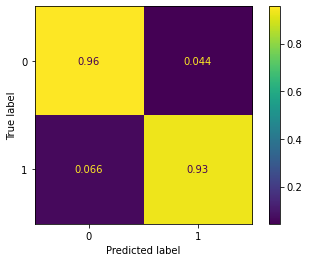

In [62]:
#confusion matrxi for train data
sklearn.metrics.plot_confusion_matrix(best_model, X_train, y_train,normalize="true") 

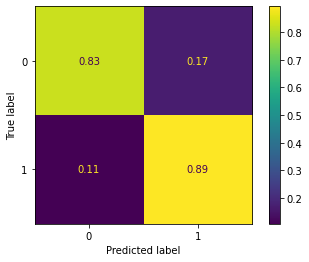

In [63]:
#confusion matrxi for test data
sklearn.metrics.plot_confusion_matrix(best_model, X_test, y_test,normalize="true") 

**OBSERVATIONS FROM MODEL 3:**

This model performed almost as good as model 1 when classes are balanced. 

But with class balancing, xgboost performed much better than logistic regression with balanced weights.

Also, the process of augmentation improved the results as compared to the previous approaches

**CONCLUSIONS AND IMPROVEMENTS REQUIRED**
 
 We need to try with other featurization methods